In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shap
import sys
sys.path.append('./pyuid3')
#sys.path.append('./EXPLAN/LORE')
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
import random



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from sklearn.svm import SVC

import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/jovyan/.conda/envs/luxenv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

In [3]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [4]:
def generate_phantom_data(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [5]:
def decision_boundary(clf1, explain_instance, X,y,f1='x1',f2='x2', dec_only=True, ax=None, palette='Set2',lux_clf=False):
    if explain_instance is not None:
        explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .1  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].

    if lux_clf:
        Z=np.array(clf1.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))
    else:
        Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])

    if type(Z) is list:
        Z=np.array(Z)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        fig,ax= plt.subplots(figsize=(9,4))

    
    ax.contour(xx, yy, Z, cmap=palette)
    if not dec_only:
        X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap=palette,ax=ax)

    if explain_instance is not None:
        ax.plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)

    ax.set(title='DecTree decision boundary')
 

In [6]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired


def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Example of local concept building (inverse sampling, density sampling prevents from building overcomplicated trees)
Local is not local at all -- the concept may be local, but its building could require a reach-out away from the locality,
On the outher hand, locality should not be considered in a global setting, becasue the simplicity migh be lost (dt covering unrelated concepts as additional branches) 
The selection of the samples to build local concepts to explain is crucial

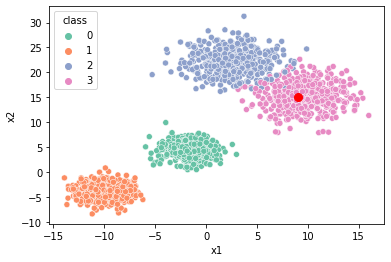

In [7]:
instance2explain = {'x1':9,'x2':15, 'class':3}
#instance2explain = {'x1':4,'x2':20, 'class':0}
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1,cluster_std=1.4)
X2,y2 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=42,cluster_std=2.4)
X2[:,0]+=5
X2[:,1]+=13
X=np.concatenate((X,X2))
y= np.concatenate((y,y2+2))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')
graph.axes.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
plt.savefig('dstree.svg', format='svg',bbox_inches='tight')

### LORE neigh

In [8]:
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

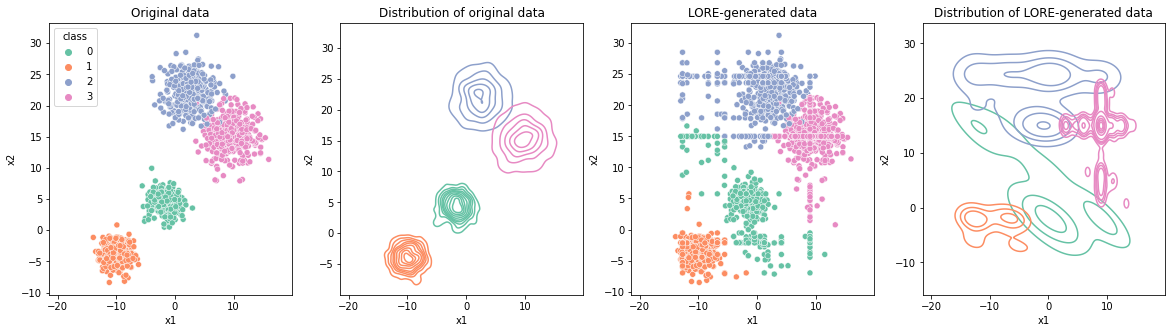

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('LORE-generated data')
axes[3].set_title('Distribution of LORE-generated data')
plt.savefig('./pix/lore-generated-data.pdf', format='pdf',bbox_inches='tight')

In [10]:
# X_explain = np.concatenate((np.array(list(instance2explain.values()))[:-1].reshape(1,-1), dataset['X']))
# exp_LORE, info_LORE = lore.explain(0, X_explain,
#                                    dataset, blackbox,
#                                    ng_function=genetic_neighborhood,
#                                    discrete_use_probabilities=True,
#                                    continuous_function_estimation=False,
#                                    returns_infos=True, 
#                                    #path='./EXPLAN/yadt/',
#                                    sep=';', log=True, depth=10)

# rule_LORE = {} 
# for i,v in  exp_LORE[0][1].items():
#     rule_LORE[i] = [v]


In [11]:
#exp_LORE

### EXPLAN neigh

In [12]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

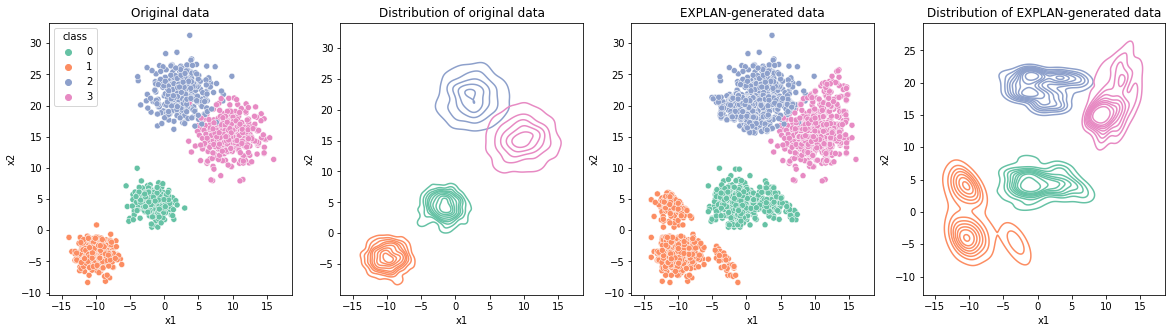

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('EXPLAN-generated data')
axes[3].set_title('Distribution of EXPLAN-generated data')
plt.savefig('./pix/explan-generated-data.pdf', format='pdf',bbox_inches='tight')

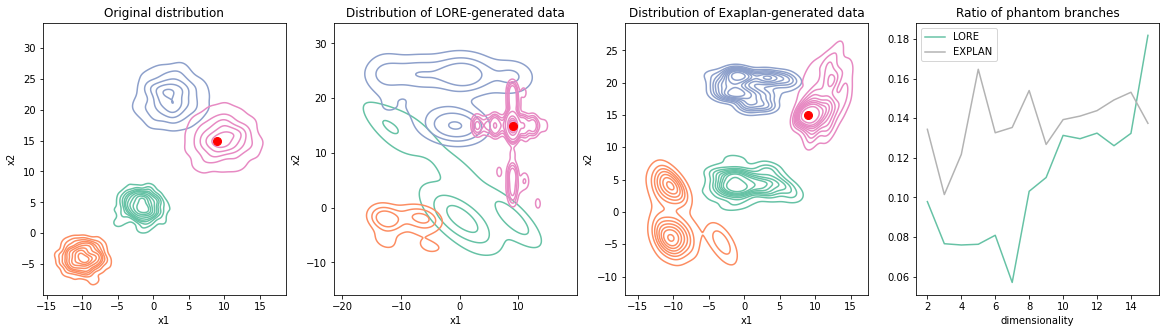

In [14]:
sdf = pd.read_csv('./results/phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
#sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan']].mean().plot(ax=axes[3], cmap='Set2')

axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
axes[3].set_title('Ratio of phantom branches')
axes[3].legend(['LORE','EXPLAN'])
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

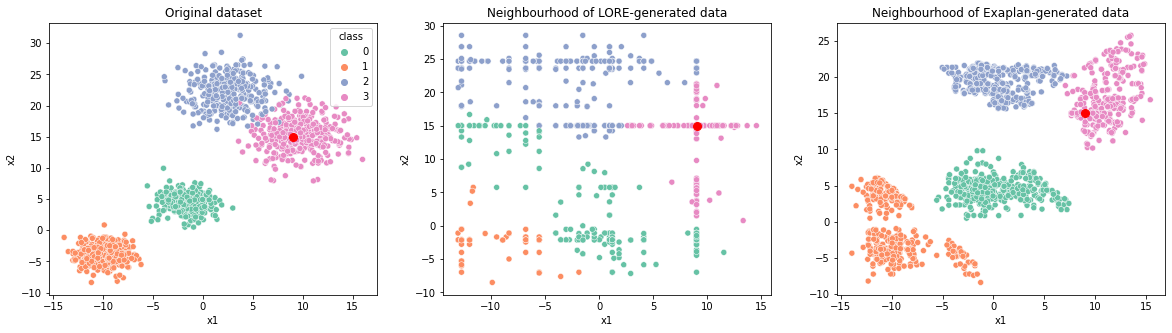

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5),sharex=False,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
#sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
#sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)

axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original dataset')
axes[1].set_title('Neighbourhood of LORE-generated data')
axes[2].set_title('Neighbourhood of Exaplan-generated data')
plt.savefig('./pix/neighbourhood-generated-data.pdf', format='pdf',bbox_inches='tight')

In [16]:
# exp_EXPLAN, info_EXPLAN = explan.Explainer(np.array(list(instance2explain.values()))[:-1],
#                                                blackbox,
#                                                dataset,
#                                                N_samples=3000,
#                                                tau=200,depth=10)
# rule_EXPLAN = {} 
# for i,v in  exp_EXPLAN[1].items():
#     rule_EXPLAN[i] = [v]

# exp_EXPLAN

### LUX neigh

In [17]:
new_cluster = train[train[target]==1]
new_cluster.loc[:,'x1'] += 15
new_cluster.loc[:,'x2'] -=  5
new_cluster.loc[:,target] = 0

train_nc = pd.concat((new_cluster,train),ignore_index=True)
train_nc

,x1,x2,class
0,6.121225,-7.089203,0
1,3.365742,-11.612597,0
2,4.375825,-8.689332,0
3,7.310319,-8.347442,0
4,5.677334,-11.584350,0
...,...,...,...
1671,1.684919,26.019938,2
1672,0.151410,3.791893,0
1673,8.360607,22.324417,2
1674,8.023501,15.642756,3


In [23]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_base_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='local',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_inverse_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='local',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, 
          grow_confidence_threshold = 0 , min_samples=50, oversampling_strategy='importance',) #added OS=both, added classifier
X_train_sample_density_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],
                                                       density_sampling=False, radius_sampling=False, 
                                         oversampling=True,parity_strategy='local',  #chamngd to true oversampling from original
                                         representative='centroid')

# lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50,oversampling_strategy='both')
# X_train_sample_density_local_shapsampling, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
#                                          exclude_neighbourhood=False, use_parity=True, 
#                                          inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
#                                          oversampling=True,parity_strategy='local',
#                                          representative='centroid')
#nearest optics based concept, measure distance, exclude everyhing larger than this threshold


lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_base, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='global',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_inverse, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='global',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba,classifier=blackbox, oversampling_strategy='importance',
          neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=2)
X_train_sample_density, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=True,parity_strategy='global',
                                         representative='centroid')
#nearest optics based concept, measure distance, exclude everyhing larger than this threshold



Index(['x1', 'x2'], dtype='object')
Done 0.9072847682119205 upsampling
Done 1.0 upsampling
Index(['x1', 'x2'], dtype='object')


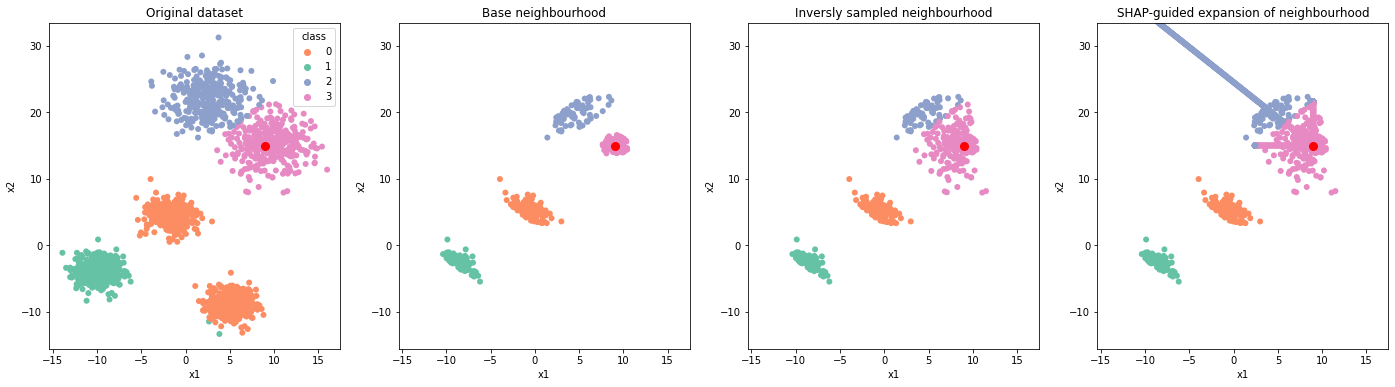

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6),sharex=False,sharey=False)
palette = dict(zip(train['class'].unique(),sns.color_palette('Set2',train['class'].nunique())))
train_nc[target] = blackbox.predict(train_nc[features])
#graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[0][0])
Zdf_lux = pd.DataFrame(X_train_sample_base_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
# graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][1], legend=False)

# graph_lux.set_ylim(graph.get_ylim())
# graph_lux.set_xlim(graph.get_xlim())

# Zdf_lux = pd.DataFrame(X_train_sample_inverse_local, columns=['x1','x2'])
# Zdf_lux[target] = blackbox.predict(Zdf_lux)
# graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][2], legend=False)

# graph_lux.set_ylim(graph.get_ylim())
# graph_lux.set_xlim(graph.get_xlim())

# Zdf_lux = pd.DataFrame(X_train_sample_density_local, columns=['x1','x2'])
# Zdf_lux[target] = blackbox.predict(Zdf_lux)
# graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][3], legend=False)
# axes[0][0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
# axes[0][1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
# axes[0][2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
# axes[0][3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

# graph_lux.set_ylim(graph.get_ylim())
# graph_lux.set_xlim(graph.get_xlim())


graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[0],edgecolor='none')
Zdf_lux = pd.DataFrame(X_train_sample_base, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1], legend=False,edgecolor='none')

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux_inverse = pd.DataFrame(X_train_sample_inverse, columns=['x1','x2'])
Zdf_lux_inverse[target] = blackbox.predict(Zdf_lux_inverse)
graph_lux = sns.scatterplot(data=Zdf_lux_inverse,x='x1', y='x2', hue='class',palette=palette,ax=axes[2], legend=False,edgecolor='none')

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux_density = pd.DataFrame(X_train_sample_density, columns=['x1','x2'])
Zdf_lux_density[target] = blackbox.predict(Zdf_lux_density)
graph_lux = sns.scatterplot(data=Zdf_lux_density,x='x1', y='x2', hue='class',palette=palette,ax=axes[3], legend=False,edgecolor='none' )



axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

axes[0].set_title('Original dataset')
axes[1].set_title('Base neighbourhood')
axes[2].set_title('Inversly sampled neighbourhood')
axes[3].set_title('SHAP-guided expansion of neighbourhood')
plt.savefig('./pix/neighbourhood-lux-data.pdf', format='pdf',bbox_inches='tight')
#plt.savefig('./pix/neighbourhood-lux-data.svg', format='svg',bbox_inches='tight')

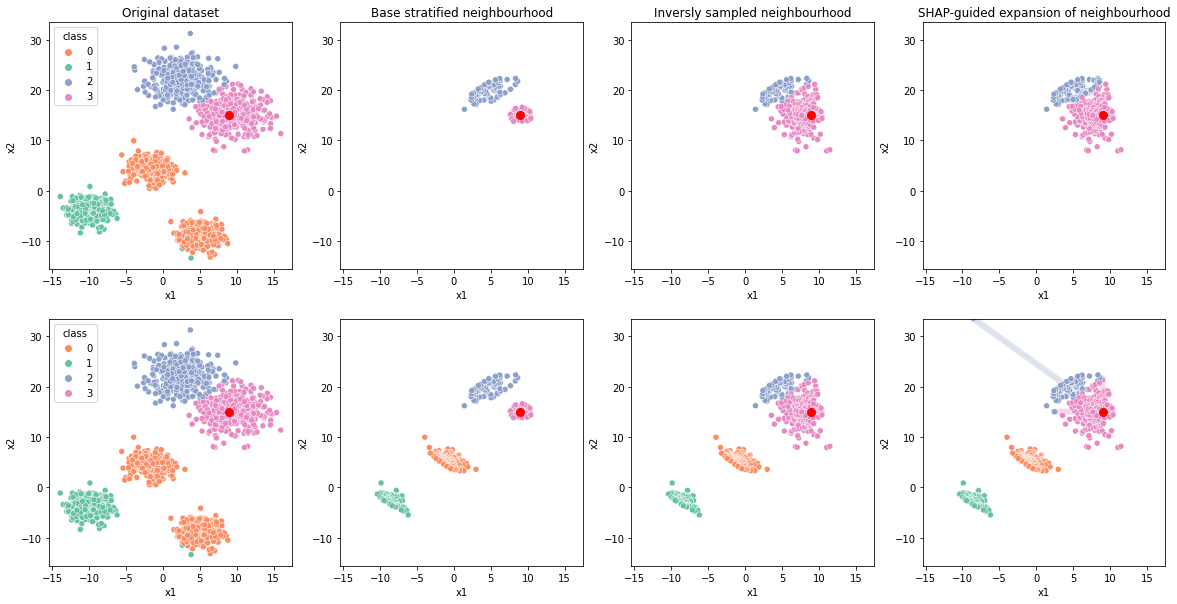

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10),sharex=False,sharey=False)
palette = dict(zip(train['class'].unique(),sns.color_palette('Set2',train['class'].nunique())))
train_nc[target] = blackbox.predict(train_nc[features])
graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[0][0])
Zdf_lux = pd.DataFrame(X_train_sample_base_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][1], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_inverse_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][2], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_density_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][3], legend=False)
axes[0][0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())


graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[1][0])
Zdf_lux = pd.DataFrame(X_train_sample_base, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][1], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_inverse, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][2], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_density, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][3], legend=False)
axes[1][0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

axes[0][0].set_title('Original dataset')
axes[0][1].set_title('Base neighbourhood')
axes[0][2].set_title('Inversly sampled neighbourhood')
axes[0][3].set_title('SHAP-guided expansion of neighbourhood')
plt.savefig('./pix/neighbourhood-lux-data.pdf', format='pdf',bbox_inches='tight')
#plt.savefig('./pix/neighbourhood-lux-data.svg', format='svg',bbox_inches='tight')

## Counterfactual generation

In [25]:
def noproba_predictor(x, clf):
    preds = clf.predict_proba(x)
    hot = np.argmax(preds,axis=1)
    result = np.zeros(preds.shape)
    for i in range(0,len(result)):
        result[i,hot[i]] = 1
    return result

In [26]:
instance2explain['x2']=17

In [27]:
luxpure = LUX(predict_proba = lambda x : noproba_predictor(x,clf=blackbox),  neighborhood_size=0.3,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=20)
luxpure.fit(train_nc[features], train_nc[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, oblique=False,
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,prune=True,parity_strategy='global',
                                         representative='centroid')


Index(['x1', 'x2'], dtype='object')


In [28]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
luxpure.justify(ei)[0]

'IF x2 <17.792954444885254 AND x2 >=7.9155495166778564 AND x1 >=3.2796318531036377 THEN class = 3 # 1.0\n'

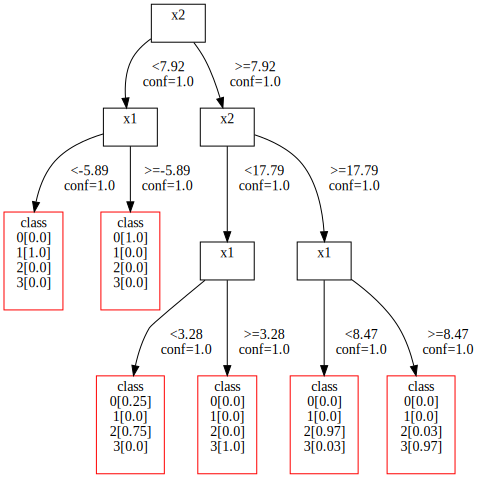

In [29]:
#prind the uncertain local tree for the given instance
import graphviz
luxpure.uid3.tree.save_dot('./pix/F2_tree-pure.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F2_tree-pure.dot')

In [30]:
lux = LUX(predict_proba = lambda x : noproba_predictor(x,clf=blackbox),classifier=blackbox,  oversampling_strategy='importance',neighborhood_size=0.3,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=20)
lux.fit(train_nc[features], train_nc[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, oblique=True,
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,prune=True,parity_strategy='global',
                                         representative='centroid')


Done 0.9117259552042161 upsampling
Done 1.0 upsampling
Index(['x1', 'x2'], dtype='object')


In [31]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 1.0460459373497648 * x1+11.512154030247453 AND x2 >=7.9155495166778564 THEN class = 3 # 1.0\n'

In [32]:
pp = np.argmax(blackbox.predict_proba(train_nc[features]),axis=1)
lpp = lux.predict(train_nc[features])

In [33]:
mask = (pp==lpp)
bg = train_nc[mask]
bg.shape

(1659, 3)

In [34]:
cf = lux.counterfactual(ei, train_nc[features], counterfactual_representative='nearest', topn=1)[0]
print(f"Counterfactual for {ei} to change from class {lux.predict(ei)[0]} to class {cf['prediction']}: \n{cf['counterfactual']}")

Counterfactual for [[ 9 17]] to change from class 3 to class 2: 
x1     6.922731
x2    19.446083
Name: 1411, dtype: float64


In [35]:
cf['rule']

{'x2': ['>=7.9155495166778564',
  '>= 1.0460459373497648 * x1+11.512154030247453']}

In [36]:
arrow = cf['counterfactual'].values-ei
arrow

array([[-2.07726883,  2.44608269]])

In [37]:
cf_medoid = lux.counterfactual(ei, train_nc[features], counterfactual_representative='medoid', topn=1)[0]
print(f"Counterfactual for {ei} to change from class {lux.predict(ei)[0]} to class {cf['prediction']}: \n{cf_medoid['counterfactual']}")

Counterfactual for [[ 9 17]] to change from class 3 to class 2: 
x1     2.558766
x2    22.085701
Name: 948, dtype: float64


In [38]:
arrow_medoid = cf_medoid['counterfactual'].values-ei
arrow_medoid

array([[-6.44123352,  5.08570086]])

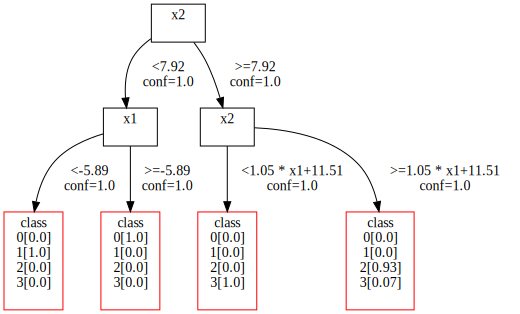

In [39]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('./pix/F2_tree-cf.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F2_tree-cf.dot')

In [40]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 1.0460459373497648 * x1+11.512154030247453 AND x2 >=7.9155495166778564 THEN class = 3 # 1.0\n'

In [41]:
i2edf = pd.DataFrame(ei, columns = features)
cfmedoid = cf_medoid['counterfactual'].to_frame().T
cfmedoid[target]= blackbox.predict(cfmedoid)
i2edf[target]= blackbox.predict(i2edf)

In [42]:
train.query("x2 < 1.0981245096727301 * x1+11.741595295656325 and x2 >=7.95315408706665 and x2 < -1.9808590280029925 * x1+10.541812766862849")

,x1,x2,class


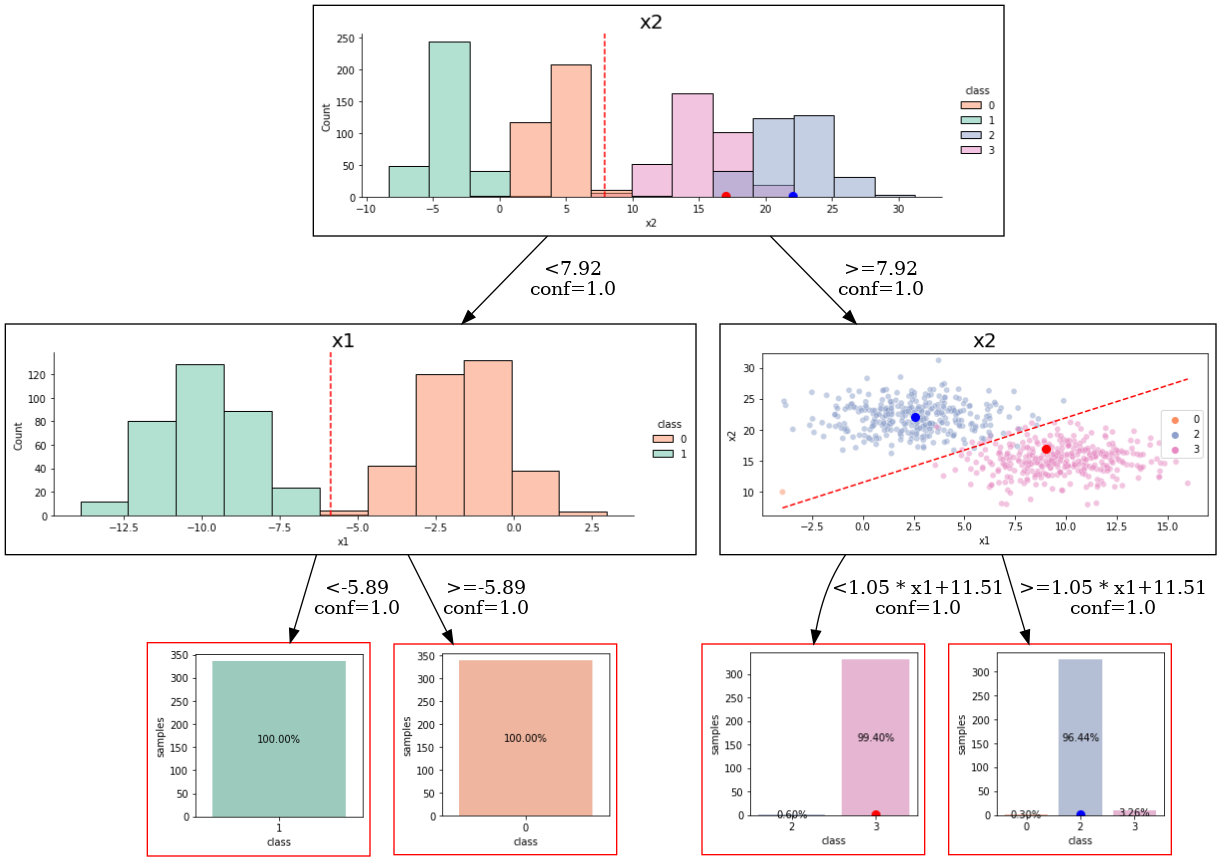

In [43]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image

#counterfactual

lux.uid3.tree.save_dot('./pix/F3_tree-cf-visual.dot',fmt='.2f',visual=True, background_data=train, instance2explain = i2edf, counterfactual=cfmedoid)
gvz=graphviz.Source.from_file('./pix/F3_tree-cf-visual.dot')
!dot -Tpng ./pix/F3_tree-cf-visual.dot > tree.png
Image('tree.png')

In [44]:
Zdf_lux['LUX predictions'] = lux.predict(Zdf_lux)
Zdf_lux['Blackbox predictions'] = blackbox.predict(Zdf_lux[features])

In [208]:
# fig, ax = plt.subplots(figsize=(10,8))
# graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='LUX predictions',palette=palette, legend=True, style='Blackbox predictions',ax=ax)
# ax.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
# ax.arrow(ei.ravel()[0],ei.ravel()[1],arrow[0][0],arrow[0][1],head_width=0.8, head_length=0.4,length_includes_head=True,linestyle='--', width=0.14, color='k')
# ax.arrow(ei.ravel()[0],ei.ravel()[1],arrow_medoid[0][0],arrow_medoid[0][1],head_width=0.8, head_length=0.4,length_includes_head=True,linestyle='--', width=0.14, color='blue')
# graph_lux.collections[0].set_sizes([100])    
# XX = Zdf_lux.sample(50)
# decision_boundary(lux,train.iloc[len(train)-1], 
#                   #Zdf_lux[features],Zdf_lux[target],
#                   XX[features],XX[target],
#                   f1='x1',f2='x2', dec_only=True, ax=ax)

# plt.savefig('./pix/F2_neighbourhood-lux-data.svg', format='svg',bbox_inches='tight')
# #plt.savefig('./pix/F2_neighbourhood-lux-data.pdf', format='pdf',bbox_inches='tight')

In [ ]:
sns.color_palette("Set2")[1]

In [ ]:
color1 = sns.color_palette("Set2")[0]
color0 = sns.color_palette("Set2")[1]
color2 = sns.color_palette("Set2")[2]
color3 = sns.color_palette("Set2")[3]

In [ ]:
"".join([f'{int(c*255):0x}' for c in color0])


In [ ]:
"".join([f'{int(c*255):0x}' for c in color1])

In [ ]:
"".join([f'{int(c*255):0x}' for c in color2])

In [ ]:
"".join([f'{int(c*255):0x}' for c in color3])

## Example of Greedy algorithm vs SHAP-powered tree (shap-powered tree is less complicated)

In [46]:
#todo; the iris dataset the complexity as a number of features used
#does it improve the consistency with shap? it does not have to?
a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
al = np.zeros(100)
b = np.random.multivariate_normal( mean=[1, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #0
bl = np.zeros(100)
c = np.random.multivariate_normal( mean=[0, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #1
cl = np.ones(100)
d = np.random.multivariate_normal( mean=[1, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #1
dl = np.ones(100)
noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,400)])
labels = np.concatenate((al,bl,cl,dl))
xor = np.concatenate((a,b,c,d))


# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# al = np.zeros(300)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,400)])
# labels = np.concatenate((al,cl))
# xor = np.concatenate((a,c))

#between
# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# al = np.zeros(300)
# d = np.random.multivariate_normal( mean=[0, 3], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# dl = np.zeros(300)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,700)])
# labels = np.concatenate((al,cl,dl))
# xor = np.concatenate((a,c,d))

#3classes
# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
# al = np.ones(100)*2
# b = np.random.multivariate_normal( mean=[2, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
# bl = np.zeros(100)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,300)])
# labels = np.concatenate((al,cl,bl))
# xor = np.concatenate((a,c,b))


noise_labels = np.abs(labels-noise)
xornoise = np.concatenate((xor, noise_labels.reshape(-1,1)), axis=1)
dataset = np.concatenate((xornoise, labels.reshape(-1,1)),axis=1)

d2 = False
if d2:
    dataset = np.concatenate((xor, labels.reshape(-1,1)),axis=1)



In [47]:
if d2:
    xords = pd.DataFrame(dataset, columns=['x1','x2','class'])
    features = ['x1','x2']
    target='class'
else:
    xords = pd.DataFrame(dataset, columns=['x1','x2','x3','class'])
    features = ['x1','x2','x3']
    target='class'

In [48]:
xords[target] = xords[target].astype(int)

In [49]:

train, test = train_test_split(xords, random_state=42)
clf = GradientBoostingClassifier(random_state=42)# svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.96

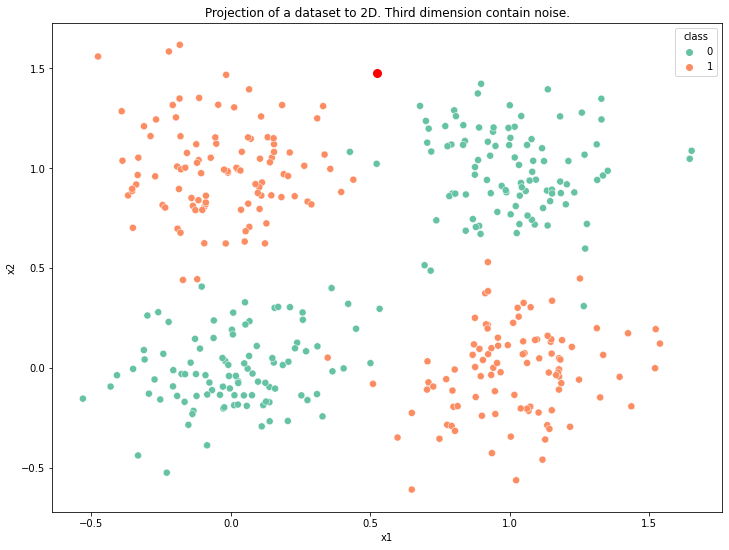

In [50]:
i2e = train.iloc[len(train)-1][features].values.reshape(1,-1)
plt.figure(figsize=(12,9))
graph=sns.scatterplot(data=xords,x='x1',y='x2',hue='class',palette='Set2')
graph.collections[0].set_sizes([50])      
features = [f for f in xords.columns if f not in ['class']]
target = 'class'
graph.axes.plot(i2e[0][0], i2e[0][1], 'or', markersize=8)
plt.title('Projection of a dataset to 2D. Third dimension contain noise.')
plt.savefig('./pix/F1_scatterplot.pdf', format='pdf',bbox_inches='tight')

In [51]:
# def noproba_predictor(x):
#     preds = clf.predict_proba(x)
#     hot = np.argmax(preds,axis=1)
#     result = np.zeros(preds.shape)
#     for i in range(0,len(result)):
#         result[i,hot[i]] = 1
#     return result

lux = LUX(predict_proba = clf.predict_proba, 
          classifier=clf, 
          neighborhood_size=int(len(train)*0.3),max_depth=2,  node_size_limit = 10, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,inverse_sampling=True, density_sampling=True, use_parity=True, oversampling=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

Done 0.8290909090909091 upsampling
Done 0.9963636363636363 upsampling
Index(['x1', 'x2', 'x3'], dtype='object')


['IF x2 >=0.43448854982852936 AND x1 >=0.4089789539575577 THEN class = 0 # 1.0\n']

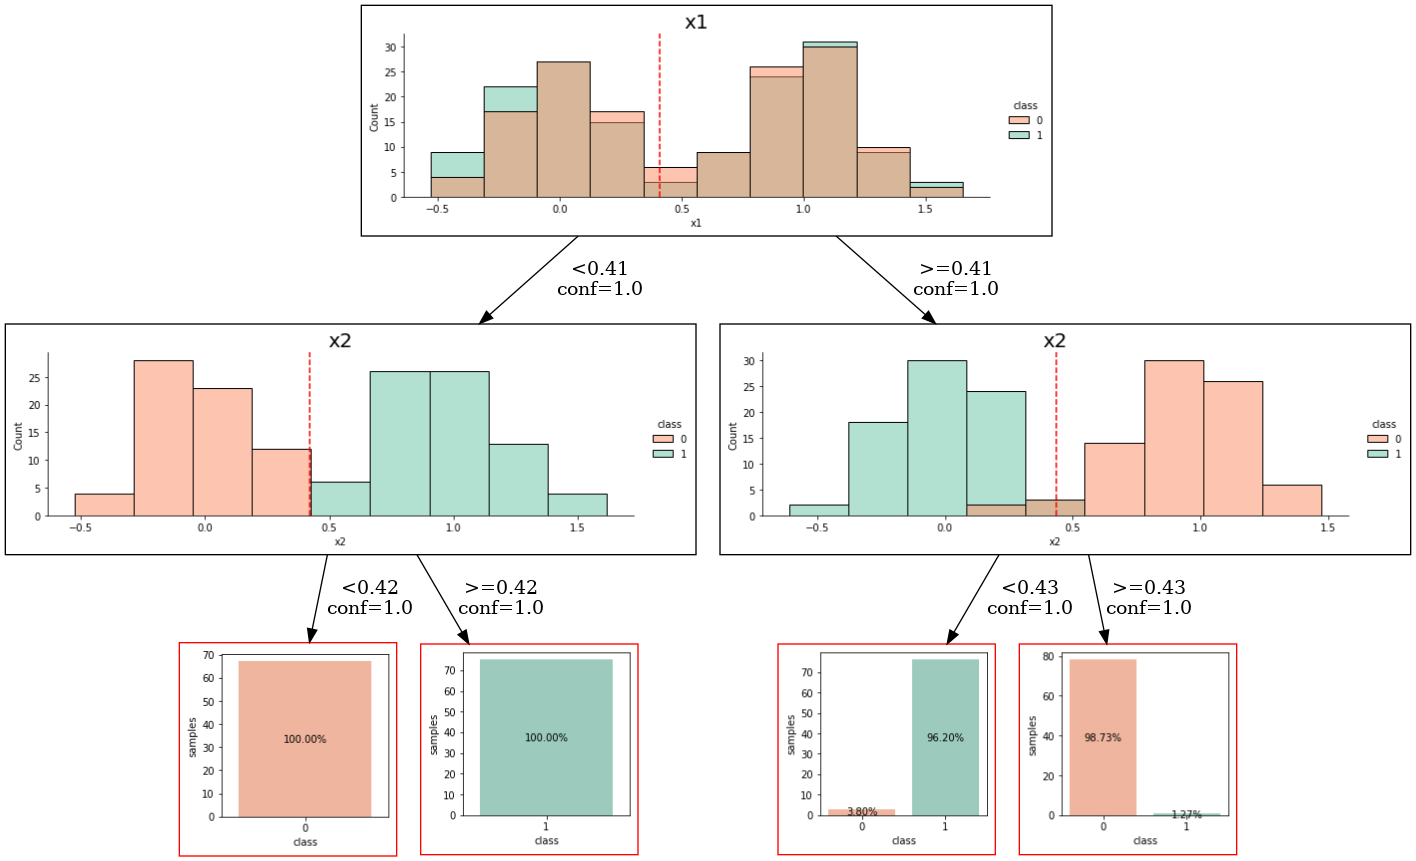

In [52]:
from IPython.display import Image
lux.uid3.tree.save_dot('./pix/greedy.dot',fmt='.2f',visual=True, background_data=train)#, instance2explain = i2e.reshape(1,-1))#, counterfactual=cfmedoid)
gvz=graphviz.Source.from_file('./pix/greedy.dot')
!dot -Tpng ./pix/greedy.dot > greedy.png
Image('greedy.png')

In [53]:
lux = LUX(predict_proba = clf.predict_proba, 
          #classifier=clf, 
          neighborhood_size=int(len(train)*0.3),max_depth=2,  node_size_limit = 10, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,inverse_sampling=True, density_sampling=True, use_parity=True, oversampling=True)
lux.justify(np.array(i2e))

Index(['x1', 'x2', 'x3'], dtype='object')


['IF x2 >=0.43448854982852936 AND x1 >=0.4002329409122467 THEN class = 0 # 1.0\n']

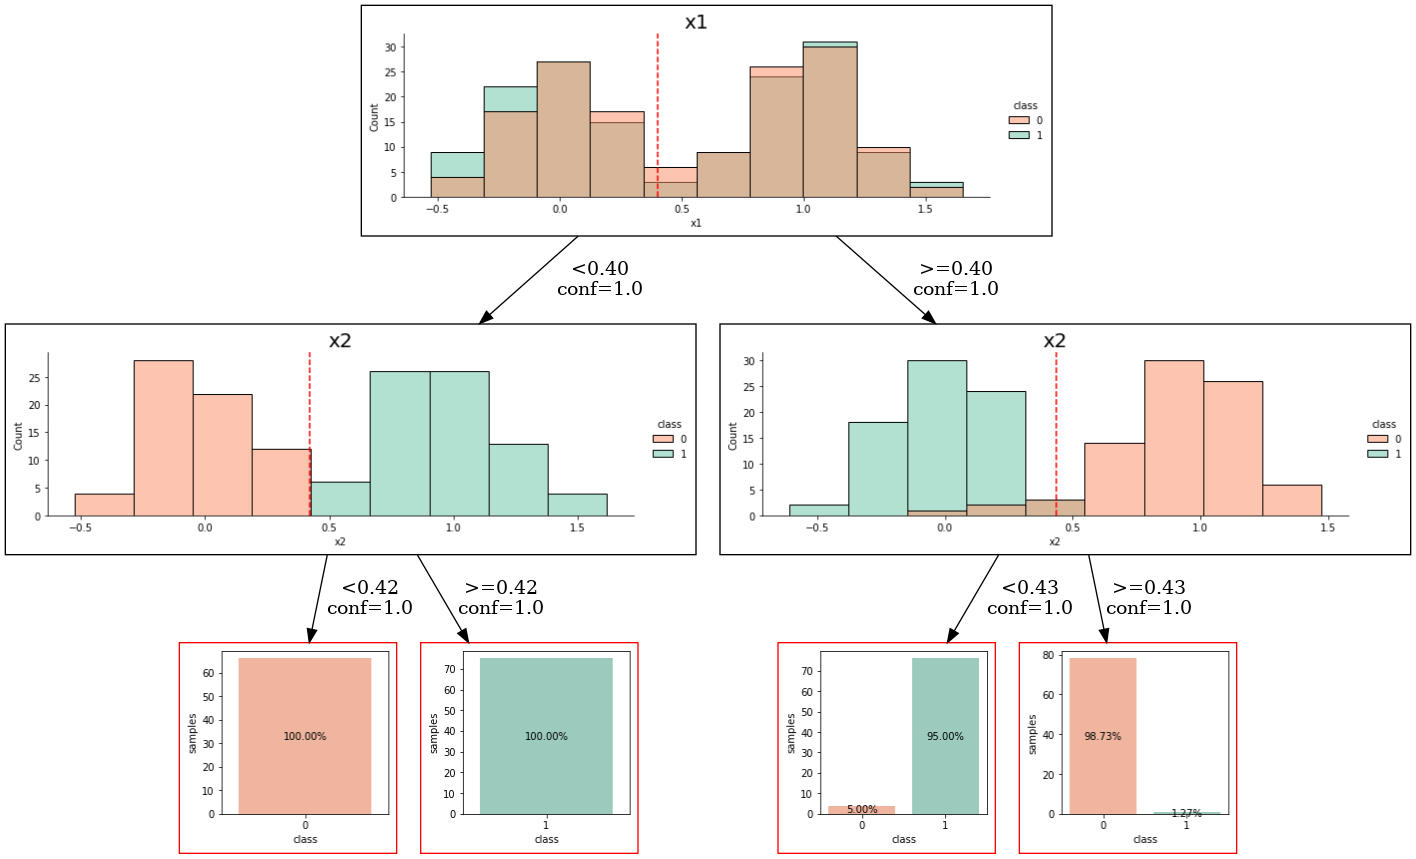

In [54]:
from IPython.display import Image
from IPython.display import Image
lux.uid3.tree.save_dot('./pix/greedy.dot',fmt='.2f',visual=True, background_data=train)#, instance2explain = i2e.reshape(1,-1))#, counterfactual=cfmedoid)
gvz=graphviz.Source.from_file('./pix/greedy.dot')
!dot -Tpng ./pix/greedy.dot > greedy.png
Image('greedy.png')

In [55]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('./pix/F1_tree-simple.dot',fmt='.2f')
# graphviz.Source.from_file('./pix/F1_tree-simple.dot')

## SHAP values

In [ ]:
# import shap
# shap.initjs()

# explainer = shap.KernelExplainer(clf.predict_proba, train[features])
# explainer =shap.Explainer(clf.predict_proba, train[features])
# shap_values_o = explainer(train[features])

In [ ]:
# shap_values=[sv for sv in np.moveaxis(shap_values_o.values, 2,0)]

In [ ]:
# shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [ ]:
# barshap = abs(shap_values_o.values).mean(0).mean(1)
# sdf = pd.DataFrame(barshap, index=['x1','x2','x3'])
# sdf.plot.barh(legend=False,cmap='Set2', figsize=(10,3))
# plt.title('Shap values for balckbox classifier')
# plt.savefig('./pix/F1_shap-values-blackbox.pdf', format='pdf',bbox_inches='tight')

In [ ]:
# lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=int(len(train)*0.6),max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
# lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,oblique=True,inverse_sampling=True, use_parity=True, oversampling=False, parity_strategy='global')

# #see the justification of the instance being classified for a given class
# lux.justify(np.array(i2e))

In [ ]:
# #prind the uncertain local tree for the given instance
# import graphviz
# lux.uid3.tree.save_dot('./pix/F1_tree-shapobliq.dot',fmt='.2f')
# graphviz.Source.from_file('./pix/F1_tree-shapobliq.dot')

## Example of data generation 

### LORE

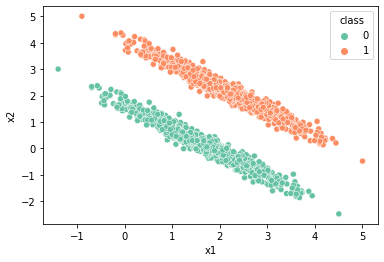

In [57]:
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')

In [268]:

instance2explain = {'x1':0,'x2':1.5, 'class':0}
#instance2explain = {'x1':2,'x2':0.0, 'class':0}
#instance2explain = {'x1':3,'x2':-1.0, 'class':0}
#instance2explain = {'x1':0,'x2':0, 'class':0}


# X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.05, random_state=0)
# X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=2, random_state=3,
#                                               n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=2,
#                                               n_classes=2)

X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = GradientBoostingClassifier()#SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

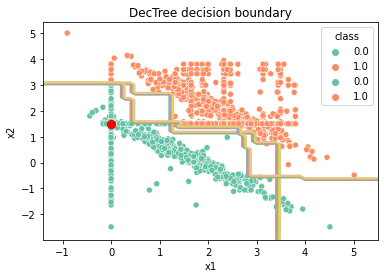

In [269]:
depth = 4
exclf_lore = DecisionTreeClassifier(max_depth=depth)
exclf_lore.fit(Zdf[features], Zdf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

### Explan

In [270]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

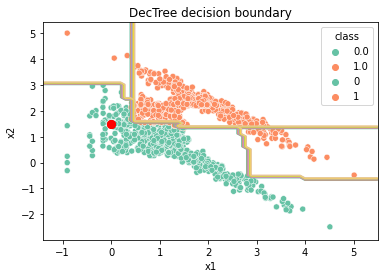

In [271]:
depth = 4
exclf_expl = DecisionTreeClassifier(max_depth=depth)
exclf_expl.fit(Ndf[features], Ndf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

# Anchor

In [272]:
X_explain = np.concatenate(([i2e], dataset['X']))
anchor_explainer = fit_anchor(dataset, train[features], train[features], train[target], train[target], X_explain)
exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1), blackbox.predict, threshold=0.9)
rule_Anchor_full = anchor2arule(exp_Anchor)


In [273]:
import pandas as pd

class AnchorPredictionWrapper():
    def __init__(self, anchor_exp):
        self.anchor_exp = anchor_exp
        self.anchor_rule = anchor2arule(self.anchor_exp)

    def predict(self, X):
        # Zakładamy, że prediction to 0 lub 1
        prediction = self.anchor_exp.exp_map['prediction']

        # Jeśli X nie jest DataFrame, konwertuj z nazwami x1, x2, ...
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            X.columns = [f'x{i+1}' for i in range(X.shape[1])]

        # Pomocnicza funkcja do parsowania warunku (np. '<=1.32')
        def parse_condition(cond):
            for op in ['<=', '>=', '==', '!=', '<', '>']:
                if cond.startswith(op):
                    return op, cond[len(op):]
            raise ValueError(f"Unsupported condition format: {cond}")

        # Budowa warunku query
        query_str = " and ".join(
            f"{col} {parse_condition(cond)[0]} {parse_condition(cond)[1]}"
            for col, cond in self.anchor_rule.items()
        )

        # Utworzenie maski logicznej
        mask = X.eval(query_str)

        # Zwróć predykcje zgodnie z maską
        preds = mask.map({True: prediction, False: 1 - prediction})

        return preds.values


In [274]:
apred = AnchorPredictionWrapper(exp_Anchor)


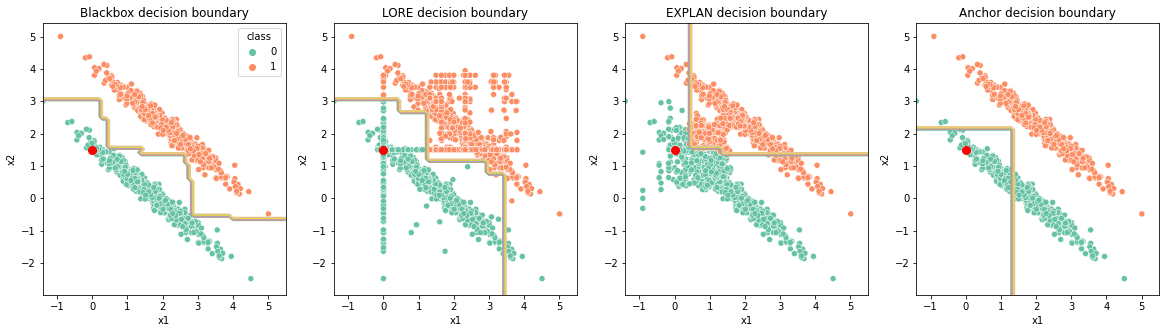

In [275]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2',ax=axes[0])
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[0])


sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[1])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[3], legend=False)
#sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[3], legend=False)
decision_boundary(apred,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[3])

axes[0].set_title('Blackbox decision boundary')
axes[1].set_title('LORE decision boundary')
axes[2].set_title('EXPLAN decision boundary')
axes[3].set_title('Anchor decision boundary')

plt.savefig('./pix/degenerated-decbounds.pdf', format='pdf',bbox_inches='tight')

### LUX

In [276]:
lux = LUX(predict_proba = blackbox.predict_proba,classifier=blackbox,neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0,min_samples=50,
         oversampling_strategy='importance')
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')


X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

Done 0.7461538461538462 upsampling
Done 1.0038461538461538 upsampling
Index(['x1', 'x2'], dtype='object')


In [277]:
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
oblique=False

y_train_sample_proba = lux.predict_proba(X_train_sample)
hot = np.argmax(y_train_sample_proba,axis=1)
y_train_sample = np.zeros(y_train_sample_proba.shape)
for i in range(0,len(y_train_sample)):
    y_train_sample[i,hot[i]] = 1
uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=[False]*len(features),class_names=np.unique(train[target]))
udata = Data.parse_uarff_from_string(uarff)
lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
if lux.classifier is not None:
    lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, 
                            #classifier=lux.classifier, 
                            discount_importance=False, depth=0,beta=1,n_jobs=1,prune=True,oblique=oblique)#,imp=rsv)
#else:
#    lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1, n_jobs=1,prune=True,oblique=oblique,imp=rsv)


In [278]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

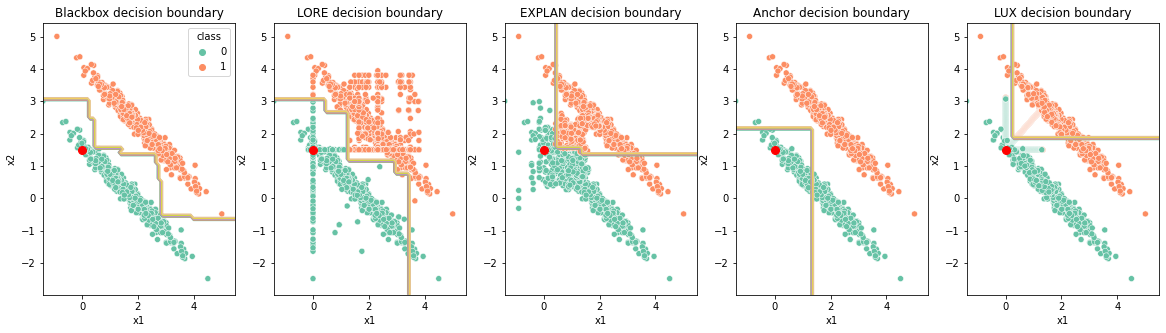

In [279]:
fig, axes = plt.subplots(1,5, figsize=(20, 5),sharex=False,sharey=False)
pl = 'Set2'
sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette=pl,ax=axes[0])
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[0])


sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette=pl,ax=axes[1], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette=pl,ax=axes[1], legend=False)
decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[1])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette=pl,ax=axes[2], legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette=pl,ax=axes[2], legend=False)
decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[3], legend=False)
#sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[3], legend=False)
decision_boundary(apred,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[3])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette=pl,ax=axes[4], legend=False)
sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette=pl,ax=axes[4], legend=False)
decision_boundary(lux,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[4], lux_clf=True)

axes[0].set_title('Blackbox decision boundary')
axes[1].set_title('LORE decision boundary')
axes[2].set_title('EXPLAN decision boundary')
axes[3].set_title('Anchor decision boundary')
axes[4].set_title('LUX decision boundary')

plt.savefig('./pix/degenerated-decbounds-nonlinear.pdf', format='pdf',bbox_inches='tight')

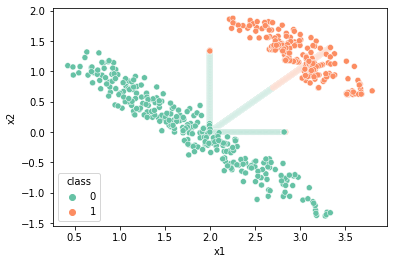

In [178]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
#sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=graph.axes)

<AxesSubplot:xlabel='x1', ylabel='x2'>

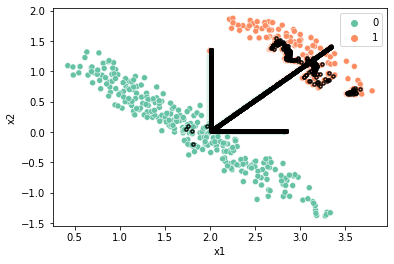

In [110]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=graph.axes)

## Lux degenerated oblique

Done 0.7461538461538462 upsampling
Done 1.0038461538461538 upsampling
Index(['x1', 'x2'], dtype='object')
Done 0.727979274611399 upsampling
Done 1.0025906735751295 upsampling
Index(['x1', 'x2'], dtype='object')
Done 0.7634961439588689 upsampling
Done 1.0 upsampling
Index(['x1', 'x2'], dtype='object')
Done 0.8227513227513228 upsampling
Done 1.0026455026455026 upsampling
Index(['x1', 'x2'], dtype='object')


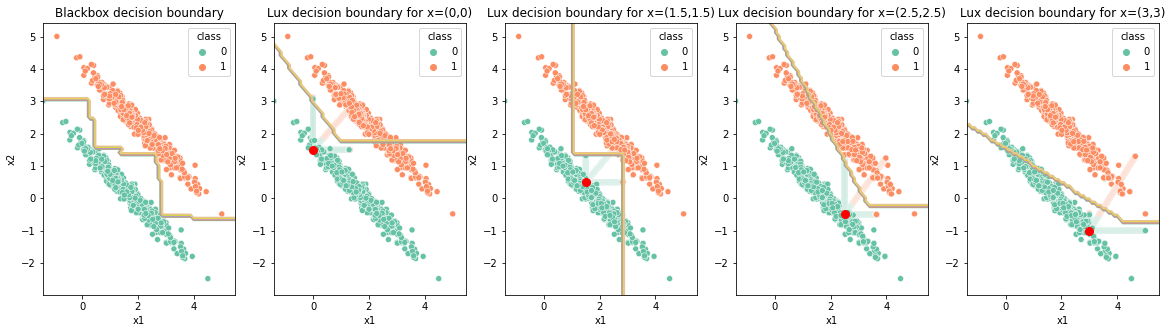

In [292]:

allinstances = [{'x1':0,'x2':1.5, 'class':0},{'x1':1.5,'x2':0.5, 'class':0},{'x1':2.5,'x2':-.5, 'class':0},
                    {'x1':3,'x2':-1, 'class':0}]
#instance2explain = {'x1':2,'x2':0.0, 'class':0}
#instance2explain = {'x1':3,'x2':-1.0, 'class':0}
#instance2explain = {'x1':0,'x2':0, 'class':0}


# X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.05, random_state=0)
# X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=2, random_state=3,
#                                               n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=2,
#                                               n_classes=2)

X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = GradientBoostingClassifier()#SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

fig, axes = plt.subplots(1,5, figsize=(20, 5),sharex=False,sharey=False)
pl = 'Set2'
sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette=pl,ax=axes[0])
decision_boundary(blackbox,None, train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[0])
axes[0].set_title('Blackbox decision boundary')
axi=1
for instance2explain in allinstances:
    #train.loc[len(train)] = instance2explain
    train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
    dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})
    
    Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
                ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
                discrete_use_probabilities=True,
                continuous_function_estimation=True)
    
    lux = LUX(predict_proba = blackbox.predict_proba,classifier=blackbox,neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0,min_samples=50,
             oversampling_strategy='importance')
    X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                             exclude_neighbourhood=False, use_parity=True, 
                                             inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                             oversampling=True,
                                             representative='centroid')
    
    
    X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                             exclude_neighbourhood=False, use_parity=True, 
                                             inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                             oversampling=False,
                                             representative='centroid')
    
    uncertain_entropy_evaluator=UncertainEntropyEvaluator()
    oblique=True
    
    y_train_sample_proba = lux.predict_proba(X_train_sample)
    hot = np.argmax(y_train_sample_proba,axis=1)
    y_train_sample = np.zeros(y_train_sample_proba.shape)
    for i in range(0,len(y_train_sample)):
        y_train_sample[i,hot[i]] = 1
    uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=[False]*len(features),class_names=np.unique(train[target]))
    udata = Data.parse_uarff_from_string(uarff)
    lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
    if lux.classifier is not None:
        lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, 
                                #classifier=lux.classifier, 
                                discount_importance=False, depth=0,beta=1,n_jobs=1,prune=True,oblique=oblique)#,imp=rsv)
    

    Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
    Zdf_lux[target] = blackbox.predict(Zdf_lux)
    
    Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
    Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)

    sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette=pl,ax=axes[axi])
    sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette=pl,ax=axes[axi], legend=False)
    decision_boundary(lux,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[axi], lux_clf=True)
    axes[axi].set_title(f"Lux decision boundary for x=({instance2explain['x1']},{instance2explain['x1']})")
    axi+=1
plt.savefig('./pix/degenerated-oblique-split.pdf', format='pdf',bbox_inches='tight')

### Lux on more complex example

In [48]:
simple=True
if not simple:
    X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
    Xdf = pd.DataFrame(X, columns=['x1','x2'])
    Xdf[target] = y
    features = [f for f in Xdf.columns if f not in [target]]
    train, test = train_test_split(Xdf, test_size=0.33, random_state=42)
else:
    X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
    transformation = [[0.4, -0.3], [0.4, -0.2]]
    transformation =[[0.8, -0.8], [0.4, -0.2]]
    X = np.dot(X, transformation)
    X2 = X.copy()
    X2[:,0]+=0.5
    X2[:,1]+=2
    X=np.concatenate((X,X2))
    y= np.concatenate((y,y+1))


    Xdf = pd.DataFrame(X, columns=['x1','x2'])
    Xdf['class'] = y

    target = 'class'
    features = [f for f in Xdf.columns if f not in [target]]
    train, test= train_test_split(Xdf, test_size=0.33, random_state=42)


blackbox = GradientBoostingClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
blackbox.fit(train[features], train[target])

GradientBoostingClassifier()

In [49]:
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf_complex,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

In [50]:
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 350)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf_complex = pd.DataFrame(neighborhood_data, columns=features)
Ndf_complex[target] = blackbox.predict(Ndf_complex[features])

In [51]:
from lux.lux import LUX

In [52]:
lux = LUX(predict_proba = blackbox.predict_proba, classifier=blackbox,neighborhood_size=0.1,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 ,oversampling_strategy='importance',min_samples=5 ,min_generate_samples=0.9)
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True,
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=False, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,
                                         representative='centroid')

Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

Done 0.7752808988764045 upsampling
Done 1.0 upsampling
Index(['x1', 'x2'], dtype='object')


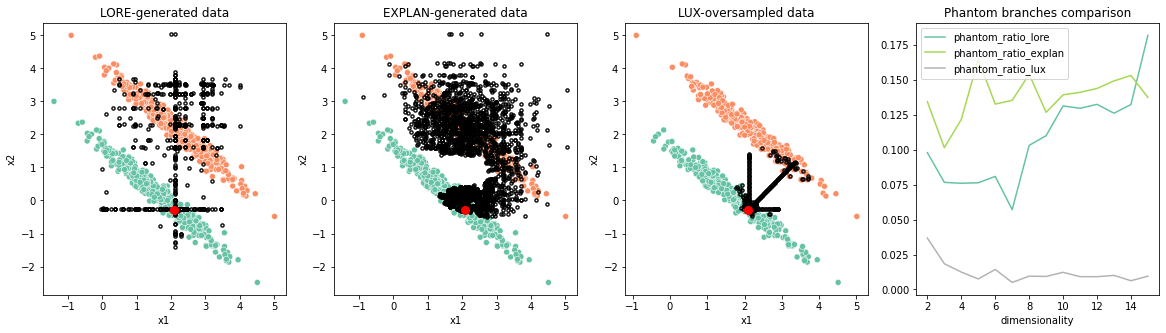

In [53]:
sdf = pd.read_csv('./results/phantoms.csv')
pl='Set2'
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2',ax=axes[0])


sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette=pl,ax=axes[0], legend=False)
sns.scatterplot(data=Zdf_complex,x='x1', y='x2',ax=axes[0], legend=False,marker="$\circ$", ec="face", color='black')
#decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[1])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette=pl,ax=axes[1], legend=False)
sns.scatterplot(data=Ndf_complex,x='x1', y='x2',ax=axes[1],marker="$\circ$", ec="face", color='black', legend=False)
#decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])

axes[0].plot(i2e[0], i2e[1], 'or', markersize=8)
axes[1].plot(i2e[0], i2e[1], 'or', markersize=8)
axes[2].plot(i2e[0], i2e[1], 'or', markersize=8)

graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette=pl,ax=axes[2],legend=False)
#sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2],legend=False)
#sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=axes[2],legend=False)
sns.scatterplot(data=X_train_sample,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot(ax=axes[3], cmap=pl)
#decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])


axes[0].set_title('LORE-generated data')
axes[1].set_title('EXPLAN-generated data')
axes[2].set_title('LUX-oversampled data')
axes[3].set_title('Phantom branches comparison')

#plt.savefig('./pix/lux-oversampling.png', format='png',bbox_inches='tight')
plt.savefig('./pix/lux-oversampling.pdf', format='pdf',bbox_inches='tight')